# NUCLEAR MASS MODELS

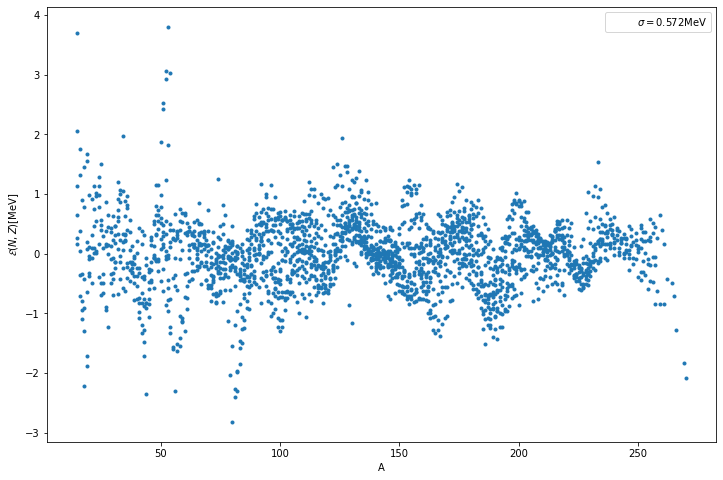

In [ ]:
import pandas as pd   #importacion de la libreria 
import matplotlib.pyplot as plt


f = open("residuals.dat", "r")  #abre el archivo .dat 
content = f.readlines() #Funcion para convertir a una lista .dat
f.close()  
data = {
    "A": [int(i[9:13]) for i in content[1:]],
    "N": [int(i[21:24]) for i in content[1:]],
    "Z": [int(i[33:36]) for i in content[1:]],
    "Residual (MEV)": [float(i[36:].strip()) for i in content[1:]],
}   #lista data 
ale = pd.DataFrame(data)   #Se crea el dataframe para trabajar con pandas y sklearn

plt.figure(figsize=(12, 8))
plt.xlabel("A")
plt.ylabel("$\mathcal{E}(N, Z)$[MeV]")
# plt.title("Residuals for DZ10")
plt.plot(
    ale.A, ale["Residual (MEV)"], ".", label="$\sigma=0.572 \mathrm{MeV}$"
)
plt.legend(frameon=True, markerscale=0)
plt.savefig("residual_dz10.pdf", dpi=600, bbox_inches="tight") #Guarda la figura 
plt.show() 

In [ ]:
ale.A

0        15
1        15
2        15
3        15
4        15
       ... 
2288    264
2289    265
2290    266
2291    269
2292    270
Name: A, Length: 2293, dtype: int64

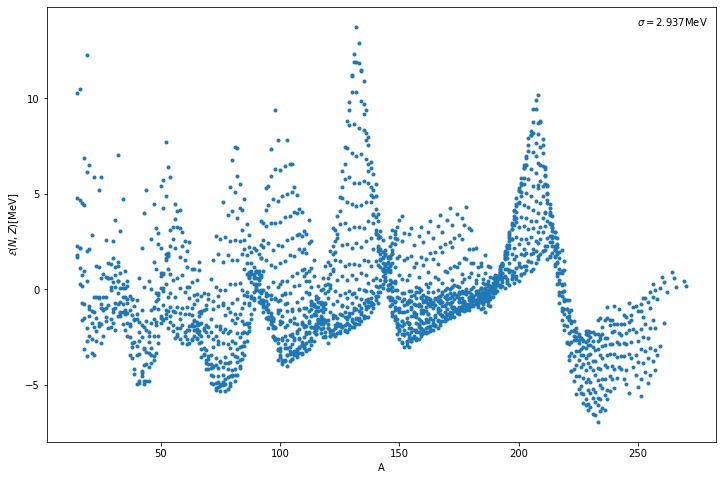

In [ ]:
f = open("residuals_liquid_drop.dat", "r")
content = f.readlines()
f.close()
data = {
    "A": [int(i[9:13]) for i in content[1:]],
    "N": [int(i[21:24]) for i in content[1:]],
    "Z": [int(i[33:36]) for i in content[1:]],
    "Residual (MEV)": [float(i[36:].strip()) for i in content[1:]],
}

goccia = pd.DataFrame(data)

plt.figure(figsize=(12,8))
plt.xlabel("A")
plt.ylabel("$\mathcal{E}(N, Z)$[MeV]")
plt.plot(
    goccia.A,
    goccia["Residual (MEV)"],
    ".",
    label="$\sigma=2.937 \mathrm{MeV}$",
)
plt.legend(frameon=False, markerscale=0)
plt.savefig("residual_liquid_drop.pdf", dpi=600, bbox_inches="tight")
plt.show()

# Liquid Drop

The first step is to prepare data to be comma separate format (it is easier to handle for building Machine Learning models). Create a CSV file:

In [ ]:
import pandas as pd
#Preaparando data del modelo de la gota liquida 
f = open("residuals_liquid_drop.dat", "r")
content = f.readlines()
f.close()
data = {
    "A": [int(i[9:13]) for i in content[1:]],
    "N": [int(i[21:24]) for i in content[1:]],
    "Z": [int(i[33:36]) for i in content[1:]],
    "Residual (MEV)": [float(i[36:].strip()) for i in content[1:]],
}

train = pd.DataFrame(data)
train.head()

,A,N,Z,Residual (MEV)
0,15,9,6,1.687563
1,15,8,7,1.789919
2,15,7,8,2.299854
3,15,6,9,4.786278
4,15,5,10,10.268696


In [ ]:
import numpy as np

print(np.mean(train["Residual (MEV)"])) #media
print(np.std(train["Residual (MEV)"])) #desviacion estandar 

-0.03574540679517848
2.93590258616667


In [ ]:
from hyperopt import hp
from hyperopt import fmin
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
#hyperopt es una libreria para optimización 

np.random.seed(2020)
Y = train["Residual (MEV)"].ravel()   #Se crea el target 
X = train.drop(["Residual (MEV)"], axis=1)   # Se crea las variables 
space = {
    "max_leaf_nodes": hp.choice("max_leaf_nodes", list(range(2, 501))),
}   #Define un space para la optimización 

#Esta entrena el arbol optimizando max_leaf_nodes 
def objective(space):
    model = DecisionTreeRegressor(
        random_state=2020, max_leaf_nodes=int(space["max_leaf_nodes"])
    )
    mse = cross_val_score(model, X, Y, cv=3, scoring="neg_mean_squared_error")
    return {
        "loss": -mse.mean(),
        "std": mse.std(),
        "status": STATUS_OK,
    }


trials = Trials()   
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=499, trials=trials)    #xxxxxxxxx
list(range(2, 501))[best["max_leaf_nodes"]]    #arroja el optimo valor

100%|██████████| 499/499 [00:29<00:00, 16.72it/s, best loss: 8.55400155248421]


4

That is, the best model was obtained with the second value in list(range(2, 501)), i.e.:

In [ ]:
list(range(2, 501))[best["max_leaf_nodes"]]

4

All the values explored and the performance of the models are saved in a new data frame:

In [ ]:
#Se crea un dataframe para el rendimiento 
performance = pd.DataFrame(
    {"max_leaf_nodes": [list(range(2, 501))[i] for i in trials.vals["max_leaf_nodes"]]})

performance["MSE_mean"] = [i["loss"] for i in trials.results] #Se crea  MSE_mean columna
performance["MSE_std"] = [i["std"] for i in trials.results]  #Se crea  MSE_std columna
performance = performance[["MSE_mean", "MSE_std", "max_leaf_nodes"]]  #Se agregan las columnas creadas al dataframe 
performance = performance.sort_values(by="MSE_mean")  #Ordena los valores respecto a MSE_mean
performance.drop_duplicates(inplace=True)  #Se ignoran index
performance.head()
#Como esta ordenado respecto a MSE_mean sabemos que el numero de hojas minimo es 4, esto se ve mas adelante en la grafica

,MSE_mean,MSE_std,max_leaf_nodes
155,8.554002,0.826360,4
252,8.823329,1.214822,5
219,8.912462,0.571805,3
197,9.363734,0.916746,2
485,10.757295,2.450720,38


In [ ]:
temp = performance.sort_values("max_leaf_nodes")   #Se ordena respecto a max_lead_nodes solo para graficar 
temp.head()

,MSE_mean,MSE_std,max_leaf_nodes
197,9.363734,0.916746,2
219,8.912462,0.571805,3
155,8.554002,0.826360,4
252,8.823329,1.214822,5
110,10.915865,2.523419,10


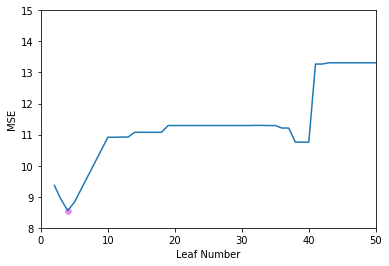

In [ ]:
plt.figure()
plt.xlabel("Leaf Number")
plt.ylabel("MSE")
plt.plot(temp.max_leaf_nodes, temp.MSE_mean)   #Graficamos el numero de hojas vs el MSE_mean
plt.xlim(0, 50)
plt.ylim(8, 15)
plt.scatter(4, 8.5554, s=30, c="violet")   #Rendimiento para datos invisibles 
plt.savefig("MSE_liquid_drop.pdf", dpi=600, bbox_inches="tight")
plt.show()

Performance on unseen data:

In [ ]:
print(list(np.sqrt(performance["MSE_mean"]))[0])

2.924722474438252


Retraining on all data:

In [ ]:
from sklearn.tree import plot_tree    #Sirve para visulalizar el arbol

rc("font", **{"family": "sans-serif", "sans-serif": ["DejaVu Sans"]})
rc("text", usetex=False)     #parametros para la letra del arbol 

model = DecisionTreeRegressor(
    random_state=2019, max_leaf_nodes=list(range(2, 501))[best["max_leaf_nodes"]]    #Se entrena los datos en base a un arbol 
).fit(X, Y)
#plt.figure(figsize=(10,10))
#plot_tree(model, filled=True , feature_names=X.columns, rounded=True) #se plotea la visualizacion grafica del arbol
#plt.savefig("tree1.pdf", dpi=600, bbox_inches="tight")
#plt.show()

In [ ]:
# Feature Engineering
X["Z_even"] = [i % 2 for i in X["Z"]]  # (Pares de Z)Hace la division y va llenando 0 o 1 la calumna, al mismo tiempo se agrega en el data frame
X["N_even"] = [i % 2 for i in X["N"]]  # (Pares de N)
X["N_Z"] = X["N"] - X["Z"]  # (Resta de N - Z)
X["N_on_Z"] = X["N"] / X["Z"] # (Division entre N/Z)
X["Z_A"] = X["Z"] / X["A"]  # (Division entre Z y A)
X["N_A"] = X["N"] / X["A"]  # (Division entre N y A)
space = {
    "max_leaf_nodes": hp.choice("max_leaf_nodes", list(range(2, 501))),
}      #defino un space para optimizar los parametros


def objective(space):
    model = DecisionTreeRegressor(
        random_state=2019, max_leaf_nodes=int(space["max_leaf_nodes"])
    )
    mse = cross_val_score(model, X, Y, cv=3, scoring="neg_mean_squared_error")
    return {
        "loss": -mse.mean(),
        "std": mse.std(),
        "status": STATUS_OK,
    }


trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=499, trials=trials)
list(range(2, 501))[best["max_leaf_nodes"]]


performance = pd.DataFrame(
    {"max_leaf_nodes": [list(range(2, 501))[i] for i in trials.vals["max_leaf_nodes"]]}
)
performance["MSE_mean"] = [i["loss"] for i in trials.results]
performance["MSE_std"] = [i["std"] for i in trials.results]
performance = performance[["MSE_mean", "MSE_std", "max_leaf_nodes"]]
performance = performance.sort_values(by="MSE_mean")
performance.drop_duplicates(inplace=True)
performance.head(n=10)

100%|██████████| 499/499 [00:43<00:00, 11.53it/s, best loss: 8.29823099791859]


,MSE_mean,MSE_std,max_leaf_nodes
468,8.298231,1.706723,9
291,8.762155,1.809754,8
154,8.894210,2.504588,10
51,9.212005,2.927228,5
451,9.519862,2.727603,6
465,9.556916,2.217715,11
333,9.585265,3.428843,4
80,10.339971,2.588868,3
401,10.389951,4.099552,7
382,10.945085,2.956995,2


Performance on unseen data:

In [ ]:
X.head()

,A,N,Z,Z_even,N_even,N_Z,N_on_Z,Z_A,N_A
0,15,9,6,0,1,3,1.500000,0.400000,0.600000
1,15,8,7,1,0,1,1.142857,0.466667,0.533333
2,15,7,8,0,1,-1,0.875000,0.533333,0.466667
3,15,6,9,1,0,-3,0.666667,0.600000,0.400000
4,15,5,10,0,1,-5,0.500000,0.666667,0.333333


In [ ]:
print(list(np.sqrt(performance["MSE_mean"]))[0])

2.8806650270238974


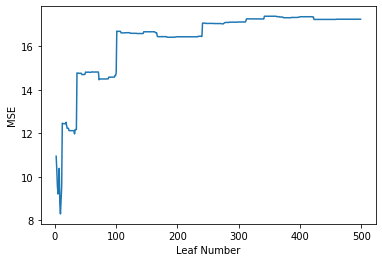

In [ ]:
temp = performance.sort_values("max_leaf_nodes")

plt.figure()
plt.xlabel("Leaf Number")
plt.ylabel("MSE")
plt.plot(temp.max_leaf_nodes, temp.MSE_mean)
plt.show()

In [ ]:
rc("font", **{"family": "sans-serif", "sans-serif": ["DejaVu Sans"]})
rc("text", usetex=False)

model = DecisionTreeRegressor(
    random_state=2019, max_leaf_nodes=list(range(2, 501))[best["max_leaf_nodes"]]
).fit(X, Y)
#plt.figure(figsize=(10,10))
#plot_tree(model, filled=True, feature_names=X.columns, rounded=True, impurity=False)
#plt.savefig("tree2.pdf", dpi=600, bbox_inches="tight")
#plt.show()
X.head()

,A,N,Z,Z_even,N_even,N_Z,N_on_Z,Z_A,N_A
0,15,9,6,0,1,3,1.500000,0.400000,0.600000
1,15,8,7,1,0,1,1.142857,0.466667,0.533333
2,15,7,8,0,1,-1,0.875000,0.533333,0.466667
3,15,6,9,1,0,-3,0.666667,0.600000,0.400000
4,15,5,10,0,1,-5,0.500000,0.666667,0.333333


The training error:

In [ ]:
print(np.sqrt(np.mean((model.predict(X) - Y) ** 2)))

2.0697689025022563


For feature importance, the [Stackoverflow post](https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python) was used as a reference

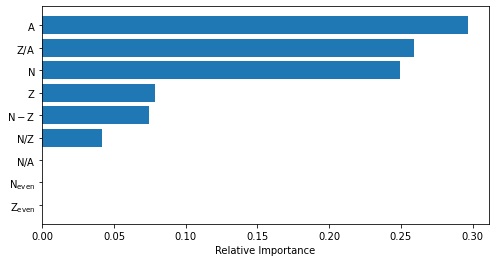

In [ ]:
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)

mapper = {
    "A": "$\mathrm{A}$",
    "N": "$\mathrm{N}$",
    "Z": "$\mathrm{Z}$",
    "Z_even": "$\mathrm{Z}_{\mathrm{even}}$",
    "N_even": "$\mathrm{N}_{\mathrm{even}}$",
    "N_Z": "$\mathrm{N-Z}$",
    "N_on_Z": "$\mathrm{N/Z}$",
    "Z_A": "$\mathrm{Z/A}$",
    "N_A": "$\mathrm{N/A}$",
}

plt.figure(figsize=(8, 4))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [mapper[features[i]] for i in indices])
plt.xlabel("Relative Importance")
plt.savefig("tree3.pdf", dpi=600, bbox_inches="tight")
plt.show()

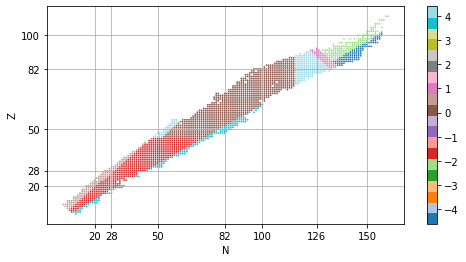

In [ ]:
corrections = pd.DataFrame({"x": X.N, "y": X.Z, "c": model.predict(X)})

rc("font", **{"family": "sans-serif", "sans-serif": ["DejaVu Sans"]})
rc("text", usetex=False)

plt.figure(figsize=(8, 4))
plt.scatter(corrections.x, corrections.y, c=corrections.c, s=0.5, cmap=plt.cm.tab20)
plt.xlabel("N")
plt.ylabel("Z")
plt.xticks([20, 28, 50, 82, 100, 126, 150])
plt.yticks([20, 28, 50, 82, 100])
plt.grid()
plt.colorbar()
plt.savefig("corrections_chart_liquid_drop.pdf", dpi=1200, bbox_inches="tight")
plt.show()

In [ ]:
corrections.head()

,x,y,c
0,9,6,-1.604679
1,8,7,-1.604679
2,7,8,0.348641
3,6,9,0.348641
4,5,10,0.348641


# Duflo-Zuker


In [ ]:
import pandas as pd

f = open("residuals.dat", "r")
content = f.readlines()
f.close()

data = {
    "A": [int(i[9:13]) for i in content[1:]],
    "N": [int(i[21:24]) for i in content[1:]],
    "Z": [int(i[33:36]) for i in content[1:]],
    "Residual (MEV)": [float(i[36:].strip()) for i in content[1:]],
}

train = pd.DataFrame(data)
train.head()

,A,N,Z,Residual (MEV)
0,15,10,5,1.136133
1,15,9,6,0.651858
2,15,8,7,0.254488
3,15,7,8,0.166684
4,15,6,9,2.052728


In [ ]:
import numpy as np

print(np.mean(train["Residual (MEV)"]))
print(np.std(train["Residual (MEV)"]))

0.002690832231143599
0.571945891636926


In [ ]:
from hyperopt import hp
from hyperopt import fmin
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score


np.random.seed(2020)
Y = train["Residual (MEV)"].ravel()
X = train.drop(["Residual (MEV)"], axis=1)
X["Z_even"] = [i % 2 for i in X["Z"]]
X["N_even"] = [i % 2 for i in X["N"]]
X["N_Z"] = X["N"] - X["Z"]
X["N_on_Z"] = X["N"] / X["Z"]
X["Z_A"] = X["Z"] / X["A"]
X["N_A"] = X["N"] / X["A"]

space = {
    "max_leaf_nodes": hp.choice("max_leaf_nodes", list(range(2, 501))),
}


def objective(space):
    model = DecisionTreeRegressor(
        random_state=2020, max_leaf_nodes=int(space["max_leaf_nodes"])
    )
    mse = cross_val_score(model, X, Y, cv=3, scoring="neg_mean_squared_error")
    return {
        "loss": -mse.mean(),
        "std": mse.std(),
        "status": STATUS_OK,
    }


trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=499, trials=trials)
print(list(range(2, 501))[best["max_leaf_nodes"]])


performance = pd.DataFrame(
    {"max_leaf_nodes": [list(range(2, 501))[i] for i in trials.vals["max_leaf_nodes"]]}
)
performance["MSE_mean"] = [i["loss"] for i in trials.results]
performance["MSE_std"] = [i["std"] for i in trials.results]
performance = performance[["MSE_mean", "MSE_std", "max_leaf_nodes"]]
performance = performance.sort_values(by="MSE_mean")
performance.drop_duplicates(inplace=True)
performance.head(n=10)

100%|██████████| 499/499 [00:41<00:00, 12.00it/s, best loss: 0.3237815744219317]
11


,MSE_mean,MSE_std,max_leaf_nodes
97,0.323782,0.151691,11
174,0.325608,0.150315,13
460,0.340072,0.140624,16
306,0.340072,0.140624,14
447,0.341245,0.139865,18
215,0.341245,0.139865,17
120,0.348728,0.135844,23
279,0.348728,0.135844,24
224,0.348728,0.135844,22
84,0.348728,0.135844,20


Error on unseen data:

In [ ]:
print(list(np.sqrt(performance["MSE_mean"]))[0])

0.569018079169662


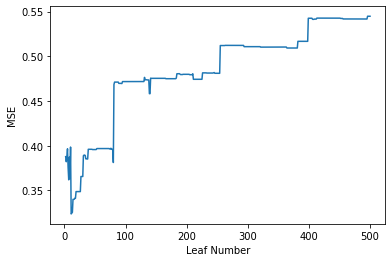

In [ ]:
temp = performance.sort_values("max_leaf_nodes")

plt.figure()
plt.xlabel("Leaf Number")
plt.ylabel("MSE")
plt.plot(temp.max_leaf_nodes, temp.MSE_mean)
plt.show()

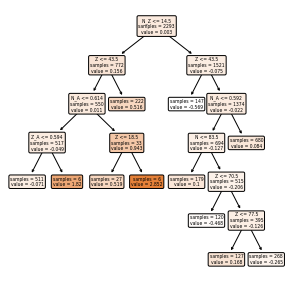

In [ ]:
rc("font", **{"family": "sans-serif", "sans-serif": ["DejaVu Sans"]})
rc("text", usetex=False)

model = DecisionTreeRegressor(
    random_state=2019, max_leaf_nodes=list(range(2, 501))[best["max_leaf_nodes"]]
).fit(X, Y)
plt.figure(figsize=(5, 5))
plot_tree(model, filled=True, feature_names=X.columns, rounded=True, impurity=False)
plt.savefig("tree4.pdf", dpi=600, bbox_inches="tight")
plt.show()

Training error:

In [ ]:
print(np.sqrt(np.mean((model.predict(X) - Y) ** 2)))

0.4714311373914842


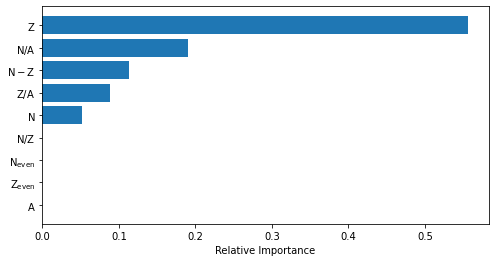

In [ ]:
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)

rc("font", **{"family": "sans-serif", "sans-serif": ["DejaVu Sans"]})
rc("text", usetex=False)

plt.figure(figsize=(8, 4))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [mapper[features[i]] for i in indices])
plt.xlabel("Relative Importance")
plt.savefig("tree5.pdf", dpi=600, bbox_inches="tight")
plt.show()

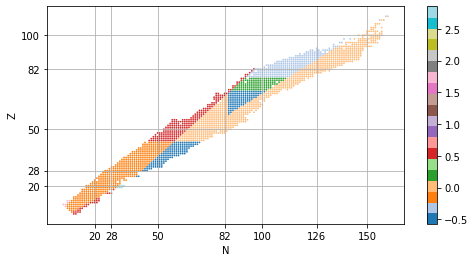

In [ ]:
corrections = pd.DataFrame({"x": X.N, "y": X.Z, "c": model.predict(X)})

rc("font", **{"family": "sans-serif", "sans-serif": ["DejaVu Sans"]})
rc("text", usetex=False)

plt.figure(figsize=(8, 4))
plt.scatter(corrections.x, corrections.y, c=corrections.c, s=0.5, cmap=plt.cm.tab20)
plt.xlabel("N")
plt.ylabel("Z")
plt.xticks([20, 28, 50, 82, 100, 126, 150])
plt.yticks([20, 28, 50, 82, 100])
plt.grid()
plt.colorbar()
plt.savefig("corrections_chart_dz10.pdf", dpi=1200, bbox_inches="tight")
plt.show()

# Duflo-Zuker: residues plots

In [ ]:
residues_dz10_with_tree = model.predict(X) - Y
residues_dz10_without_tree = Y

Using and adopting [the Stackoverflow post](https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data/20012350):

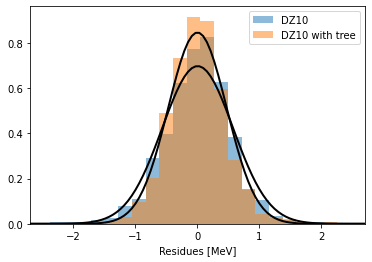

In [ ]:
from scipy.stats import norm

rc("font", **{"family": "sans-serif", "sans-serif": ["DejaVu Sans"]})
rc("text", usetex=False)

plt.figure()
plt.xlim((-2.7, 2.7))
plt.xlabel("Residues [MeV]")
n, bins, patches = plt.hist(
    residues_dz10_without_tree, bins=30, alpha=0.5, density=True, label="DZ10"
)
p = norm.pdf(
    np.linspace(-3, 3, 100),
    np.mean(residues_dz10_without_tree),
    np.std(residues_dz10_without_tree),
)
plt.plot(np.linspace(-3, 3, 100), p, "k", linewidth=2)
plt.hist(
    residues_dz10_with_tree, bins=bins, alpha=0.5, density=True, label="DZ10 with tree"
)
p = norm.pdf(
    np.linspace(-3, 3, 100),
    np.mean(residues_dz10_with_tree),
    np.std(residues_dz10_with_tree),
)
plt.plot(np.linspace(-3, 3, 100), p, "k", linewidth=2)
plt.legend()
plt.show()

To match the fit color to the default, the [color names are printed](https://stackoverflow.com/questions/42086276/get-default-line-colour-cycle):

In [ ]:
print(plt.rcParams["axes.prop_cycle"].by_key()["color"])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


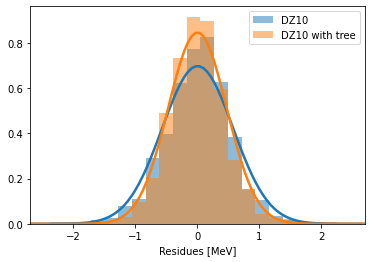

In [ ]:
plt.figure(figsize=(6, 4))
plt.xlim((-2.7, 2.7))
plt.xlabel("Residues [MeV]")
n, bins, patches = plt.hist(
    residues_dz10_without_tree, bins=30, alpha=0.5, density=True, label="DZ10"
)
p = norm.pdf(
    np.linspace(-3, 3, 100),
    np.mean(residues_dz10_without_tree),
    np.std(residues_dz10_without_tree),
)
plt.plot(np.linspace(-3, 3, 100), p, "#1f77b4", linewidth=2.5)
plt.hist(
    residues_dz10_with_tree, bins=bins, alpha=0.5, density=True, label="DZ10 with tree"
)
p = norm.pdf(
    np.linspace(-3, 3, 100),
    np.mean(residues_dz10_with_tree),
    np.std(residues_dz10_with_tree),
)
plt.plot(np.linspace(-3, 3, 100), p, "#ff7f0e", linewidth=2.5)
plt.legend()
plt.savefig("histo.pdf", dpi=600)
plt.show()